In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Conv1D, Dense, Embedding
from tensorflow.keras.layers import GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.models import Model

In [2]:
# Load the data
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2022-10-31 20:23:29--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  1.36MB/s    in 0.4s    

2022-10-31 20:23:30 (1.36 MB/s) - ‘spam.csv’ saved [503663/503663]



In [3]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# rename the columns
df.columns = ['labels', 'data']

In [6]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values
textData = df['data']

In [36]:
print(textData[1])

Ok lar... Joking wif u oni...


In [8]:
# split the data
df_train, df_test, Y_train, Y_test = train_test_split(df['data'], Y, test_size=0.33)

In [9]:
# convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [10]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print("Found %s unique tokens." % V)

Found 7100 unique tokens.


In [14]:
# pad sequences to have N x T matrix
data_train = pad_sequences(sequences_train)
print("shape of data train tensor:", data_train.shape)

#length of sequence
T = data_train.shape[1]

shape of data train tensor: (3733, 189)


In [15]:
# pad sequences to have N x T matrix
data_test = pad_sequences(sequences_test, maxlen=T)
print("shape of data test tensor:", data_test.shape)

shape of data test tensor: (1839, 189)


In [16]:
# create the model

#embedding dimentionality
D = 20

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(i, x)


In [17]:
# compile and fit
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Training model...")
r = model.fit(
    data_train,
    Y_train,
    epochs=5,
    validation_data=(data_test, Y_test)
)

Training model...
Epoch 1/5
117/117 [==============================] - 4s 23ms/step - loss: 0.3758 - accuracy: 0.8642 - val_loss: 0.2840 - val_accuracy: 0.8630
Epoch 2/5
117/117 [==============================] - 2s 21ms/step - loss: 0.1267 - accuracy: 0.9462 - val_loss: 0.1415 - val_accuracy: 0.9320
Epoch 3/5
117/117 [==============================] - 3s 22ms/step - loss: 0.0209 - accuracy: 0.9936 - val_loss: 0.0912 - val_accuracy: 0.9761
Epoch 4/5
117/117 [==============================] - 3s 21ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.0938 - val_accuracy: 0.9793
Epoch 5/5
117/117 [==============================] - 3s 23ms/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 0.1228 - val_accuracy: 0.9761


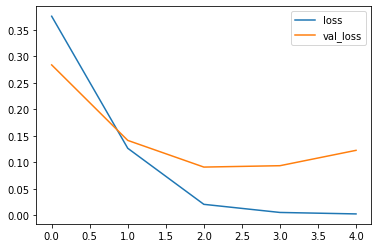

In [18]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

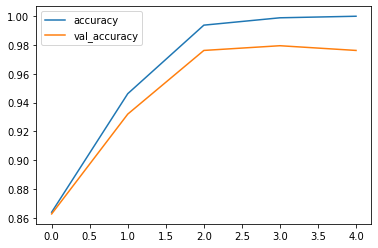

In [19]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

58/58 [==============================] - 0s 5ms/step
Confusion confusion matrix, w/o normalization
[[1587    0]
 [ 252    0]]


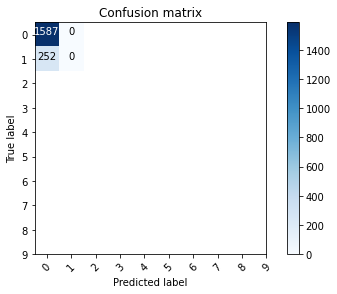

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion confusion matrix, w/o normalization")
  
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() /2.0
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j], fmt),
             horizontalalignment="center",
             color="white" if cm[i,j]>thresh else "black")
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

p_test = model.predict(data_test).argmax(axis=1)
cm = confusion_matrix(Y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [22]:
# labels
labels = '''ham
spam'''.split()

In [34]:
print(sequences_test[2])

[91, 34, 37, 1348, 44, 5901, 559, 2124, 1819, 2627, 64, 54, 49, 227, 113, 258, 21, 22, 1971, 59, 3438, 2285]


In [43]:
# show some misclassified samples
misclassified_idx = np.where(p_test != Y_test)[0]
i = np.random.choice(misclassified_idx)
print("True label: %s Predicted label: %s" % (labels[Y_test[i]],labels[p_test[i]]));
print("True data: %s Predicted data: %s" % (df_test[i],p_test[i]));

True label: spam Predicted label: ham
True data: Shall i ask one thing if you dont mistake me. Predicted data: 0
